In [1]:
import keras

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
#Mean Variance Estimation Method
import pandas as pd

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset.dropna()
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

In [3]:
# train and test data set
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# mean and var data set
mean_dataset = train_dataset.sample(frac=0.5 , random_state=0)
var_dataset = train_dataset.drop(mean_dataset.index)

print(mean_dataset.head())
print(var_dataset.head())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
161  16.0          6         250.0       105.0  3897.0          18.5   
182  28.0          4         107.0        86.0  2464.0          15.5   
295  35.7          4          98.0        80.0  1915.0          14.4   
86   14.0          8         304.0       150.0  3672.0          11.5   
394  44.0          4          97.0        52.0  2130.0          24.6   

     Model Year  USA  Europe  Japan  
161          75  1.0     0.0    0.0  
182          76  0.0     1.0    0.0  
295          79  1.0     0.0    0.0  
86           73  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
146  28.0          4          90.0        75.0  2125.0          14.5   
69   12.0          8         350.0       160.0  4456.0          13.5   
378  38.0          4         105.0        63.0  2125.0          14.7   
310  38.1          4          89.0        60.0  196

In [4]:
# model definition function

from keras.models import Model
from keras.layers import Input, Dense, Dropout
dropout_rate = 0.5
def model_fn():
    inputs = Input(shape=(9,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model

In [5]:

mean_model = model_fn()
mean_model.compile(loss="mean_squared_error", optimizer='adam')

var_model = model_fn()
var_model.compile(loss="mean_squared_error", optimizer='adam')


Instructions for updating:
Colocations handled automatically by placer.


In [6]:
train_stats = train_dataset.describe()
print(train_stats.head())
train_stats.pop("MPG")
train_stats.transpose()
def norm(x):
    return (x - train_stats.loc['mean']) / train_stats.loc['std']

train_labels = train_dataset.pop('MPG')
mean_labels = mean_dataset.pop('MPG')
var_labels = var_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

normed_train_data = norm(train_dataset)
normed_mean_data = norm(mean_dataset)
normed_var_data = norm(var_dataset)
normed_test_data = norm(test_dataset)


              MPG   Cylinders  Displacement  Horsepower       Weight  \
count  314.000000  314.000000    314.000000  314.000000   314.000000   
mean    23.310510    5.477707    195.318471  104.869427  2990.251592   
std      7.728652    1.699788    104.331589   38.096214   843.898596   
min     10.000000    3.000000     68.000000   46.000000  1649.000000   
25%     17.000000    4.000000    105.500000   76.250000  2256.500000   

       Acceleration  Model Year         USA      Europe       Japan  
count    314.000000  314.000000  314.000000  314.000000  314.000000  
mean      15.559236   75.898089    0.624204    0.178344    0.197452  
std        2.789230    3.675642    0.485101    0.383413    0.398712  
min        8.000000   70.000000    0.000000    0.000000    0.000000  
25%       13.800000   73.000000    0.000000    0.000000    0.000000  


In [7]:
# train the models

EPOCHS = 100
mean_model.fit(normed_mean_data, mean_labels, epochs=EPOCHS, validation_split=0.2, verbose=0)

mean_predictions = mean_model.predict(normed_var_data)

squared_residuals = (var_labels.values.reshape(-1,1) - mean_predictions) ** 2
# print(squared_residuals)
var_model.fit(normed_var_data, squared_residuals, epochs=EPOCHS, validation_split=0.2, verbose=0)


Instructions for updating:
Use tf.cast instead.


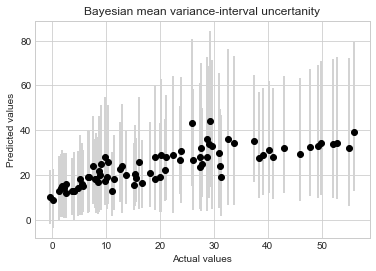

In [10]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

normed_test_data = normed_test_data.dropna()

mean_predictions = mean_model.predict(normed_test_data)
var_predictions = var_model.predict(normed_test_data)

var_predictions[var_predictions < 0] = 0
ci= 0.95
lower_bound = mean_predictions - ci*np.sqrt(var_predictions)
upper_bound = mean_predictions + ci*np.sqrt(var_predictions)

error_variance = np.array([lower_bound.T, upper_bound.T])
error_variance = error_variance.reshape(2,78)

x = normed_test_data
y_pred = var_model.predict(x)
y_actual = test_labels

plt.errorbar( y_pred, y_actual, yerr=error_variance, fmt='o', color='black',
             ecolor='lightgray', elinewidth=2, capsize=0 )
plt.title('Bayesian mean variance-interval uncertanity')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
#plt.figsize=(12, 10)



In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

print(y_actual.size)
print(y_pred.size)
x = normed_test_data
y_pred = var_model.predict(x)
y_actual = test_labels
dy = 0.8*y_pred

plt.errorbar(y_pred, y_actual, yerr=dy, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)

In [ ]:
# plotting the error

import numpy as np
import matplotlib.pyplot as plt

x = normed_test_data
y_pred = var_model.predict(x)
y_actual = test_labels

# example error bar values that vary with x-position
error = 0.1*x
# print("X")
# print(x)
# print("y_pred")
# print(y_pred)
# print("test_labels")
# print(test_labels)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)
ax0.errorbar(y_actual, y_pred, fmt='o')
ax0.set_title('variable, symmetric error')


In [ ]:
import keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
model = model_fn()
model.compile(loss=lambda y,f: tilted_loss(0.5,y,f), optimizer='adam')
lowerq_model = model_fn()
lowerq_model.compile(loss=lambda y,f: tilted_loss(0.025,y,f), optimizer='adam')
upperq_model = model_fn()
upperq_model.compile(loss=lambda y,f: tilted_loss(0.9725,y,f), optimizer='adam')